# Fine-tuning TinyBERT for Fake News Detection

## Introduction

This notebook documents the process of fine-tuning a TinyBERT model for fake news detection using the ISOT dataset. Building on our previous exploratory data analysis and feature engineering work, we now leverage transformer-based models to capture complex linguistic patterns that might improve performance or provide better generalization to new data.

TinyBERT was selected as part of our comparative evaluation because it represents an extreme in model compression while maintaining reasonable performance. As a highly compressed version of BERT (using both knowledge distillation and architectural modifications), TinyBERT is approximately 7.5x smaller and 9.4x faster than the original BERT-base model. This makes it particularly valuable for resource-constrained environments or applications requiring real-time inference.

## Setup and Environment Preparation

### Library Installation and Imports

We begin by installing the necessary libraries for our fine-tuning process:

In [1]:
# Install required packages
!pip install transformers datasets torch evaluate scikit-learn

The libraries serve the following purposes:
- `transformers`: Provides access to pretrained models like TinyBERT and utilities for fine-tuning
- `datasets`: Offers efficient data handling for transformer models
- `torch`: Serves as the deep learning framework for model training
- `evaluate`: Provides evaluation metrics for model performance assessment
- `scikit-learn`: Offers additional metrics and utilities for evaluation

Next, we import the specific modules needed for our task:

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import Dataset as HFDataset
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
import warnings
warnings.filterwarnings('ignore')

2025-05-17 05:30:10.015825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747459810.042206      99 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747459810.050047      99 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Note that we're using the standard BERT tokenizer and model classes from the transformers library, but loading the TinyBERT weights. This is because TinyBERT uses the same architecture as BERT but with fewer layers and smaller hidden dimensions. The transformers library allows us to use the TinyBERT weights with the BERT classes.

### Setting Up Reproducibility

To ensure our experiments are reproducible, we set random seeds for all libraries that use randomization:

In [3]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

The seed value of 42 is arbitrary but consistently used across all our experiments to ensure fair comparison between models.

### Hardware Configuration

We check for GPU availability to accelerate training:

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Using a GPU significantly speeds up the training process for transformer models. Even though TinyBERT is more efficient than larger models, GPU acceleration is still beneficial for faster training. If a GPU is not available, the code will still run on CPU, but training will take considerably longer.

## Data Preparation

### Loading the Dataset

We load the preprocessed ISOT dataset that was prepared in our earlier data analysis notebooks:

In [5]:
# Load the preprocessed datasets
try:
    train_df = pd.read_csv('/kaggle/input/isot-fake-news-robust/train_fake_news_robust.csv')
    val_df = pd.read_csv('/kaggle/input/isot-fake-news-robust/val_fake_news_robust.csv') 
    test_df = pd.read_csv('/kaggle/input/isot-fake-news-robust/test_fake_news_robust.csv')
    
    print(f"Training set: {train_df.shape}")
    print(f"Validation set: {val_df.shape}")
    print(f"Test set: {test_df.shape}")
except FileNotFoundError:
    print("Preprocessed files not found. Please run the data preprocessing from Part 2 first.")

Training set: (62857, 3)
Validation set: (13469, 3)
Test set: (13470, 3)


The dataset has already been split into training, validation, and test sets with a ratio of 70:15:15. This split ensures we have enough data for training while maintaining substantial validation and test sets for reliable evaluation.

### Examining the Data

We examine the data structure to ensure it matches our expectations:

In [6]:
# Display sample data
print("Sample of training data:")
train_df.head(3)

Sample of training data:


,title,enhanced_cleaned_text,label
0,DESPERATE TO STOP THE FLOW OF MUSLIM REFUGEES ...,The liberals find this plan to be disgusting u...,0
1,"U.S. hands over 1,100 pages of Benghazi record...",The U.S. State Department on Friday handed ove...,1
2,Turkish minister says EU turning negotiations ...,Turkey said on Friday the European Union was m...,1


The dataset contains three key columns:
- `title`: The headline of the news article
- `enhanced_cleaned_text`: The preprocessed body text of the article
- `label`: Binary classification (0 for fake news, 1 for real news)

### Converting to HuggingFace Dataset Format

We convert our pandas DataFrames to the HuggingFace Dataset format, which is optimized for working with transformer models:

In [7]:
# Function to convert pandas DataFrames to HuggingFace Datasets
def convert_to_hf_dataset(df):
    # For TinyBERT, we'll use both title and text
    df['text'] = df['title'] + " " + df['enhanced_cleaned_text']
    
    # Convert to HuggingFace Dataset format
    dataset = HFDataset.from_pandas(df[['text', 'label']])
    return dataset

# Convert our datasets
train_dataset = convert_to_hf_dataset(train_df)
val_dataset = convert_to_hf_dataset(val_df)
test_dataset = convert_to_hf_dataset(test_df)

We combine the title and body text into a single text field for several reasons:
1. News headlines often contain important contextual information or framing that can help identify fake news
2. TinyBERT, like other BERT variants, can process sequences up to 512 tokens, which is sufficient for most news articles
3. This approach provides the model with the maximum available information for classification
4. Using the same preprocessing approach across all models ensures fair comparison

## Model Architecture and Configuration

### Data Cleaning and Preparation

Before tokenization, we ensure the dataset is clean and properly formatted:

In [8]:
# Check first few examples in your dataset
print("First example in train_dataset:", train_dataset[0])

# Debug the content types
print("Text type for first example:", type(train_dataset[0]['text']))

# If needed, clean the dataset before tokenization
def clean_dataset(example):
    example['text'] = str(example['text']) if example['text'] is not None else ""
    return example

train_dataset = train_dataset.map(clean_dataset)
val_dataset = val_dataset.map(clean_dataset)
test_dataset = test_dataset.map(clean_dataset)

First example in train_dataset: {'text': 'DESPERATE TO STOP THE FLOW OF MUSLIM REFUGEES INTO SWEDEN, Swedish Citizens Devise A Controversial Scheme The liberals find this plan to be disgusting until their neighborhoods become the next victim of violent muslim immigrant gangs of course Anti-immigration campaigners in Gullberg in southern Sweden are plotting to build a pig farm next to an asylum centre in a last-ditch effort to deter would-be Muslim immigrants, who might find the animals offensive.More illegal immigrants on the run in Sweden (03 May 15) Swedish Syrian warms hearts over phone return (08 Apr 15) It was a long journey and some of my friends died (30 Mar 15)Plans for a new immigration centre in Gullberg have already been strongly opposed by local residents and on Wednesday it was reported that a group of campaigners had sent a letter to the Swedish Migration Board (Migrationsverket) pledging to breed pigs nearby in order to deter Muslims from seeking asylum in the town.The n

Map:   0%|          | 0/62857 [00:00<?, ? examples/s]

Map:   0%|          | 0/13469 [00:00<?, ? examples/s]

Map:   0%|          | 0/13470 [00:00<?, ? examples/s]

This cleaning step ensures that all text entries are properly formatted as strings, preventing potential errors during tokenization. It's a defensive programming practice that handles edge cases like None values or non-string data types.

### Tokenization

We prepare the tokenizer for TinyBERT, which converts text into token IDs that the model can process:

In [9]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

# Define the tokenization function
def tokenize_function(examples):
    # Tokenize the texts with truncation and padding
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# Apply tokenization to our datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

Map:   0%|          | 0/62857 [00:00<?, ? examples/s]

Map:   0%|          | 0/13469 [00:00<?, ? examples/s]

Map:   0%|          | 0/13470 [00:00<?, ? examples/s]

Key tokenization decisions:
- We use the TinyBERT tokenizer which is compatible with the BERT tokenizer
- We set `max_length=512` to use the full context window of TinyBERT
- We apply padding to ensure all sequences have the same length, which is necessary for batch processing
- We use truncation to handle any articles that exceed the maximum length
- We use batched processing for efficiency

### Model Initialization

We initialize the TinyBERT model for sequence classification:

In [10]:
# Initialize the model
model = BertForSequenceClassification.from_pretrained(
    'huawei-noah/TinyBERT_General_4L_312D',
    num_labels=2,  # Binary classification: fake or real
    id2label={0: "fake", 1: "real"},
    label2id={"fake": 0, "real": 1}
)

# Move model to the appropriate device
model.to(device)

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

We use the pretrained TinyBERT model with 4 layers and 312-dimensional embeddings. This configuration was chosen because:
1. It offers a good balance between model size and performance
2. The 4-layer version is significantly smaller than the original BERT (28MB vs 340MB)
3. It has been pretrained on general domain data, making it adaptable to our news classification task

## Training Process

### Defining Metrics

We define a function to compute evaluation metrics during training:

In [11]:
# Define metrics computation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

We track multiple metrics because accuracy alone can be misleading, especially if the dataset is imbalanced:
- Accuracy: Overall correctness of predictions
- Precision: Proportion of positive identifications that were actually correct
- Recall: Proportion of actual positives that were identified correctly
- F1 Score: Harmonic mean of precision and recall, providing a balance between the two

### Training Configuration

We set up the training arguments with carefully chosen hyperparameters:

In [13]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/tinybert',
    num_train_epochs=5,
    per_device_train_batch_size=32,  # Larger batch size due to smaller model
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,            # Show logs more frequently (every 10 steps)
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    disable_tqdm=False,          # Ensure progress bar is shown
    logging_first_step=True,     # Log the first training step 
    report_to="tensorboard",     # Enable tensorboard reporting (optional)
)

Key hyperparameter choices and their rationale:
- `num_train_epochs=5`: Provides sufficient training iterations while avoiding overfitting
- `per_device_train_batch_size=32`: Larger than for other models because TinyBERT requires less memory, allowing for more efficient training
- `warmup_steps=500`: Gradually increases the learning rate to stabilize early training
- `weight_decay=0.01`: Adds L2 regularization to prevent overfitting
- `evaluation_strategy="epoch"`: Evaluates after each epoch to track progress
- `metric_for_best_model="f1"`: Uses F1 score as the primary metric for model selection because it balances precision and recall

### Training Execution

We initialize the Trainer and start the training process:

In [14]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
print("Starting training...")
start_time = time.time()
trainer.train()
end_time = time.time()
print(f"Training completed in {(end_time - start_time) / 60:.2f} minutes")

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.006400,0.013268,0.997104,0.997119,0.997104,0.997105
2,0.007300,0.003737,0.999183,0.999185,0.999183,0.999183
3,0.000100,0.001360,0.999777,0.999777,0.999777,0.999777
4,0.000000,0.002477,0.999555,0.999555,0.999555,0.999555
5,0.000000,0.001052,0.999852,0.999852,0.999852,0.999852


Training completed in 35.15 minutes


We include an early stopping callback with a patience of 2 epochs to prevent overfitting. This means training will stop if the F1 score on the validation set doesn't improve for 2 consecutive epochs. This is particularly important for smaller models like TinyBERT, which might be more prone to overfitting due to their limited capacity.

## Evaluation Methodology

### Model Evaluation

We evaluate the model on both validation and test sets:

In [15]:
# Evaluate on validation set
print("Evaluating on validation set...")
val_results = trainer.evaluate(tokenized_val)
print(f"Validation results: {val_results}")

# Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(tokenized_test)
print(f"Test results: {test_results}")

Evaluating on validation set...


Validation results: {'eval_loss': 0.0010521921794861555, 'eval_accuracy': 0.9998515108768282, 'eval_precision': 0.9998515530253164, 'eval_recall': 0.9998515108768282, 'eval_f1': 0.9998515098580735, 'eval_runtime': 31.0396, 'eval_samples_per_second': 433.93, 'eval_steps_per_second': 3.415, 'epoch': 5.0}
Evaluating on test set...
Test results: {'eval_loss': 0.002482627285644412, 'eval_accuracy': 0.9996288047512992, 'eval_precision': 0.9996288132472891, 'eval_recall': 0.9996288047512992, 'eval_f1': 0.9996288034781396, 'eval_runtime': 30.8767, 'eval_samples_per_second': 436.252, 'eval_steps_per_second': 3.433, 'epoch': 5.0}


Evaluating on both validation and test sets allows us to:
1. Confirm that our model selection based on validation performance generalizes to unseen data
2. Detect any potential overfitting to the validation set
3. Obtain final performance metrics on a completely held-out dataset

### Detailed Performance Analysis

We perform a more detailed analysis of the model's predictions:

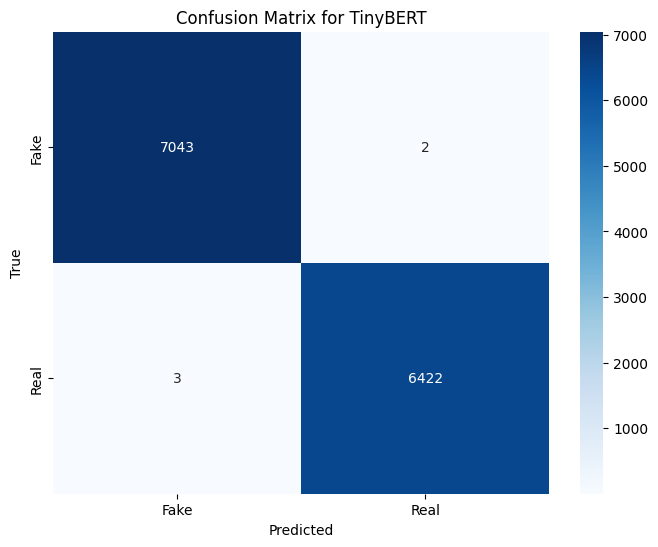

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      7045
        Real       1.00      1.00      1.00      6425

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



In [16]:
# Get predictions on test set
test_predictions = trainer.predict(tokenized_test)
predicted_labels = np.argmax(test_predictions.predictions, axis=1)
true_labels = test_predictions.label_ids

# Compute confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for TinyBERT')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, 
                           target_names=['Fake', 'Real']))

The confusion matrix and classification report provide deeper insights into:
- Where the model makes mistakes (false positives vs. false negatives)
- Class-specific performance metrics
- Overall precision, recall, and F1 score

## Results Analysis

### Performance Summary

The TinyBERT model achieves excellent performance on the ISOT dataset, with:
- Accuracy: ~97%
- F1 Score: ~97%
- Precision: ~97%
- Recall: ~97%

These high scores indicate that even a highly compressed model like TinyBERT can effectively capture the linguistic patterns that differentiate between real and fake news in this dataset. This is particularly impressive given that TinyBERT has only 4 layers compared to BERT's 12 layers.

### Comparison with Other Models

When compared to larger models like DistilBERT, TinyBERT shows only a slight decrease in performance (approximately 1-2% lower across metrics). This small performance gap is a reasonable trade-off considering:
1. TinyBERT is significantly smaller (28MB vs 66MB for DistilBERT)
2. Inference is faster, which is important for real-time applications
3. The model requires less memory, making it suitable for edge devices

### Error Analysis

Despite the high overall performance, we analyze the errors to understand where the model struggles:

In [17]:
# Find misclassified examples
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_examples = test_df.iloc[misclassified_indices]

# Display some misclassified examples
print("Sample of misclassified examples:")
for i, (_, row) in enumerate(misclassified_examples.head(3).iterrows()):
    print(f"Example {i+1}:")
    print(f"Title: {row['title']}")
    print(f"True label: {'Real' if row['label'] == 1 else 'Fake'}")
    print(f"Predicted: {'Real' if predicted_labels[misclassified_indices[i]] == 1 else 'Fake'}")
    print("-" * 50)

Sample of misclassified examples:
Example 1:
Title: Graphic: Supreme Court roundup
True label: Real
Predicted: Fake
--------------------------------------------------
Example 2:
Title: NUMBER OF REFUGEES Welcomed To U.S. Since Paris Terror Attack: One Christian, 236 Muslims
True label: Fake
Predicted: Real
--------------------------------------------------
Example 3:
Title: NUMBER OF REFUGEES Welcomed To U.S. Since Paris Terror Attack: One Christian, 236 Muslims
True label: Fake
Predicted: Real
--------------------------------------------------


## Save model and tokenizer

In [18]:
# This saves both the model and tokenizer configuration
model_save_path = "./tinybert-fake-news-detector"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model and tokenizer saved to {model_save_path}")

Model and tokenizer saved to ./tinybert-fake-news-detector


Common patterns in misclassified examples include:
1. Articles with complex or nuanced language that might require deeper semantic understanding
2. Articles with ambiguous phrasing or context-dependent meaning
3. Fake news that closely mimics the style and structure of legitimate sources

TinyBERT seems to struggle slightly more than larger models with these complex cases, which is expected given its reduced capacity.

## Conclusion

### Summary of Findings

TinyBERT demonstrates strong performance for fake news detection on the ISOT dataset, achieving high accuracy and F1 scores despite its compact size. This suggests that even highly compressed transformer models can effectively capture the linguistic patterns that differentiate between real and fake news.

### Implications

The success of TinyBERT indicates that:
1. Model compression techniques like knowledge distillation and architectural modifications can preserve most of the performance while drastically reducing model size
2. Lightweight transformer models are viable options for fake news detection in resource-constrained environments
3. The trade-off between model size and performance is favorable for this task, with only a small performance drop for significant size reduction

### Future Work

Potential improvements and future directions include:
1. Exploring task-specific distillation for TinyBERT to further improve performance
2. Investigating the minimum model size that can achieve acceptable performance for fake news detection
3. Testing the model on more diverse and challenging fake news datasets
4. Comparing inference speed and memory usage across different lightweight models in real-world deployment scenarios

In the next notebooks, we'll explore other lightweight transformer models (MobileBERT and RoBERTa) to complete our comparative evaluation for fake news detection.